The aim of this project is to test the effectiveness of complex encoding for DNA sequences

1. Test to establish if virus can be classified correctly as belonging to influenza group or HIV
2. Test to check if VQC can distinguish fake from real genomic data: this is achieved by creating two labelled data sets. One based on real genomic data and the second based on fake random genomic data set with a similar proportion of the bases ACGT 
3. Swap test to see if single base substitutions can be detected or become invisible due to the encoding technique
4. Possible pretraining of first half of VQC and then finetuning of second part 

In [1]:
import pennylane as qml
from pennylane import numpy as np
import random as rn
from matplotlib import pyplot as plt

In [2]:
def determine_Qubits(seq):

    '''
    This function returns the number of qubits required to represent a DNA sequence
    '''
    
    i=0
    while True:
        if 2**i>=len(seq):
            n=i
            break
        i+=1
        
    return n


def DNA_encoder_complex(seq):

    '''
    Complex encoding of a DNA sequence
    The function returns a list of complex numbers
    
    Copyright Berend Rah 2024 https://www.linkedin.com/in/berendrah/
    https://github.com/Quvance


    '''
    
    DNA_list=list(seq)
    encode_DNA={'A':'-1','T':'1','C':'-1j','G':'1j', 'R':'-1+j'}   # R is an ambiguous result which could either be A or G
    encoded_seq=np.array([complex(encode_DNA[base]) for base in DNA_list])
    return encoded_seq


def DNA_encoder(seq):

    '''
    the information is encoded into angle encoding i.e. fractional rotations of pi for A,C,G, and T

    '''

    encoded_seq=np.empty(len(seq))

    for i in range(len(seq)):

        if seq[i]=='A':
            encoded_seq[i]=0
        elif seq[i]=='C':
            encoded_seq[i]=-np.pi/2
        elif seq[i]=='G':
            encoded_seq[i]=np.pi
        elif seq[i]=='T':
            encoded_seq[i]=3*np.pi/2 

    return encoded_seq

    

def random_DNA_gen(GC_percentage, seq_length):
    '''
    This function creates a random DNA seq of length 'seq_length' based on the percentages of GC

    Copyright 2024 Berend Rah -- quvance.com

    '''
    seq_list=[]
    
    
    for i in range(seq_length):
        if np.random.random()<GC_percentage/100:
            seq_list.append('GC'[rn.randint(0,1)])
        else:
            seq_list.append('AT'[rn.randint(0,1)])

    seq=''.join(seq_list)
    
    return seq

                
        
    

def percentage(DNA_seq):

    '''
    This function returns the percentages of A,C,G and T for a given DNA sequence
    '''

    return DNA_percentages



def mutate_seq(seq,mut):

    '''
    
    This function mutates mut random bases of sequence seq
    Choose a random position and change the base to one of the other 3 bases
    
    '''
    seq_list=list(seq)
    bases=['A','C','G','T']
    pos_list=[]
    
    for i in range(mut):
        samePosition=True
        while samePosition:
            pos=rn.randint(0,len(seq)-1)
            
            if pos not in pos_list:
                samePosition=False
                pos_list.append(pos)
        
        sameBase=True
        while sameBase:
            new_base=bases[rn.randint(0,3)]
            if new_base!=seq_list[pos]:
                sameBase=False
                seq_list[pos]=new_base

    seq=''.join(seq_list)
    return seq          
                
                
                



In [3]:
#testing above function
seq='ACGTTTACGT'
mut=mutate_seq(seq,7)
print(seq+'\n',mut)
print(len(seq),len(mut))

ACGTTTACGT
 TCGAGCGAGA
10 10


TGCGCCCCGCGCGGTG
CATCTAATATTTCATT
0.03906249999999978
ACCCGTTTATTTGCCT
ACCCGTTTCTATGCCT
0.6640624999999998
CATGTAATTGTTTTGA CATGTAATTGTTTTGA
0.9999999999999993
ACCCGTTTATTTGCCT
TACCCGTTTATTTGCC
0.03125
ACCC
TACC


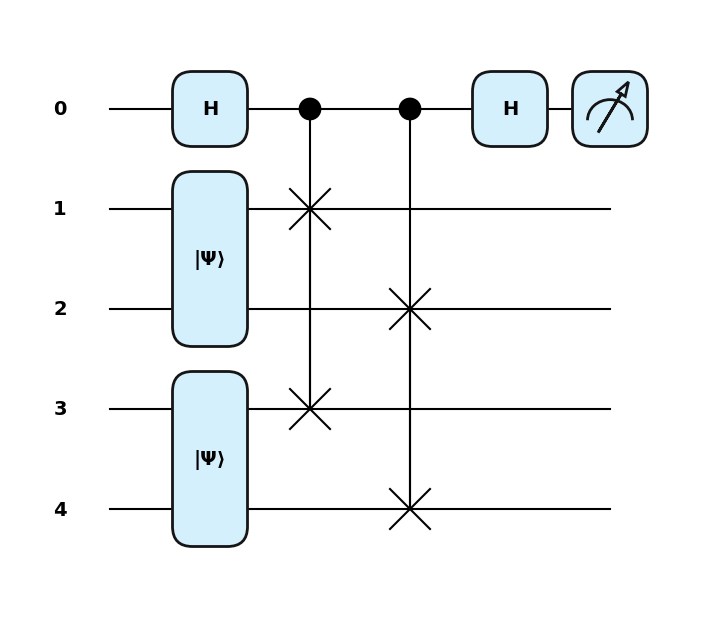

In [23]:
dev = qml.device("lightning.qubit", wires=range(9))



@qml.qnode(dev)
def SWAP_test(seq1,seq2,qubits):

    '''
    There are 2 quantum state of equal size - each one of size (qubits-1)/2
    
    '''

    enc_seq1=DNA_encoder_complex(seq1)
    enc_seq2=DNA_encoder_complex(seq2)

    qml.AmplitudeEmbedding(features=enc_seq1, wires=range(1,int((qubits-1)/2+1)), normalize=True, pad_with=0.)
    qml.AmplitudeEmbedding(features=enc_seq2, wires=range(int((qubits-1)/2+1),qubits), normalize=True, pad_with=0.)

    #qml.AmplitudeEmbedding(features=enc_seq1, wires=range(1,5), normalize=True, pad_with=0.)
    #qml.AmplitudeEmbedding(features=enc_seq2, wires=range(5,9), normalize=True, pad_with=0.)

    qml.Hadamard(0)
    for i in range(1,int((qubits-1)/2+1)):
        qml.CSWAP(wires=[0, i, i+int((qubits-1)/2)])  # pairwise comparison of qubits
    qml.Hadamard(0)

    probs=qml.probs(wires=[0])

    return probs

seq_1=random_DNA_gen(90,16)
print(seq_1)
seq_2=random_DNA_gen(10,16)
print(seq_2)

prob=SWAP_test(seq_1, seq_2 ,9)
print(prob[0]*2-1)

seq_1='ACCCGTTTATTTGCCT'
print(seq_1)
seq_2='ACCCGTTTCTATGCCT'
print(seq_2)

prob=SWAP_test(seq_1, seq_2 ,9)
print(prob[0]*2-1)

seq_1=random_DNA_gen(20,16)
seq_2=seq_1
print(seq_1,seq_2)

prob=SWAP_test(seq_1, seq_2 ,9)
print(prob[0]*2-1)

#shift by 1 position

seq_1='ACCCGTTTATTTGCCT'
print(seq_1)
seq_2='TACCCGTTTATTTGCC'
print(seq_2)

prob=SWAP_test(seq_1, seq_2 ,9)
print(prob[0]*2-1)

seq_1='ACCC'
print(seq_1)
seq_2='TACC'
print(seq_2)


# This line is to expand the circuit to see the operators
#partial(qml.devices.preprocess.decompose, stopping_condition = lambda obj: False, max_expansion=1)

qml.draw_mpl(SWAP_test, decimals = 2, style="pennylane")(seq_1,seq_2,5)
plt.show()


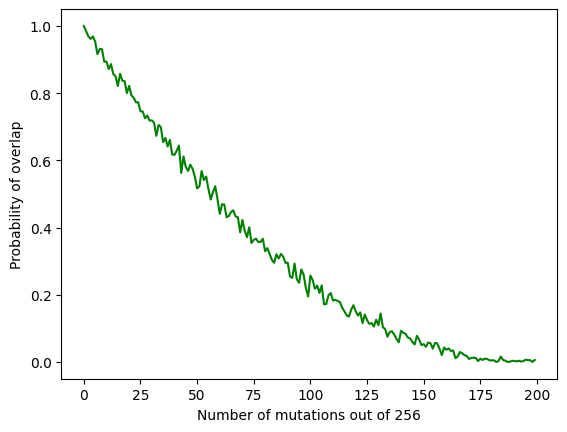

In [7]:
'''

Testing different sequence length and artifical mutatations with the Swap Test


'''

i=8
seq_len=2**i
dev = qml.device("default.qubit", wires=range(2*i+1))

@qml.qnode(dev)
def SWAP_test(seq1,seq2,qubits):

    '''
    There are 2 quantum state of equal size - each one of size (qubits-1)/2
    
    '''

    enc_seq1=DNA_encoder_complex(seq1)
    enc_seq2=DNA_encoder_complex(seq2)

    qml.AmplitudeEmbedding(features=enc_seq1, wires=range(1,int((qubits-1)/2+1)), normalize=True, pad_with=0.)
    qml.AmplitudeEmbedding(features=enc_seq2, wires=range(int((qubits-1)/2+1),qubits), normalize=True, pad_with=0.)

    #qml.AmplitudeEmbedding(features=enc_seq1, wires=range(1,5), normalize=True, pad_with=0.)
    #qml.AmplitudeEmbedding(features=enc_seq2, wires=range(5,9), normalize=True, pad_with=0.)

    qml.Hadamard(0)
    for i in range(1,int((qubits-1)/2+1)):
        qml.CSWAP(wires=[0, i, i+int((qubits-1)/2)])  # pairwise comparison of qubits
    qml.Hadamard(0)

    probs=qml.probs(wires=[0])

    return probs


    
seq_1=random_DNA_gen(50,seq_len)

m=np.arange(200, dtype=int)
probs=np.arange(200,dtype=float)
for j in range (200):
    seq_2=mutate_seq(seq_1,j)
    prob=SWAP_test(seq_1,seq_2,2*i+1)
    probs[j]=prob[0]*2-1

plt.plot(m,probs,color='g')
plt.xlabel('Number of mutations out of '+ str(2**i))
plt.ylabel('Probability of overlap')

plt.show()


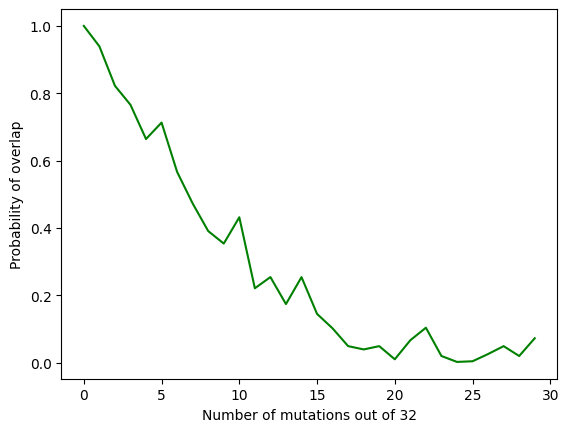

In [6]:
'''

Testing different sequence length and artifical mutatations with the Swap Test


'''

i=5
seq_len=2**i
dev = qml.device("default.qubit", wires=range(2*i+1))

@qml.qnode(dev)
def SWAP_test(seq1,seq2,qubits):

    '''
    There are 2 quantum state of equal size - each one of size (qubits-1)/2
    
    '''

    enc_seq1=DNA_encoder_complex(seq1)
    enc_seq2=DNA_encoder_complex(seq2)

    qml.AmplitudeEmbedding(features=enc_seq1, wires=range(1,int((qubits-1)/2+1)), normalize=True, pad_with=0.)
    qml.AmplitudeEmbedding(features=enc_seq2, wires=range(int((qubits-1)/2+1),qubits), normalize=True, pad_with=0.)

    #qml.AmplitudeEmbedding(features=enc_seq1, wires=range(1,5), normalize=True, pad_with=0.)
    #qml.AmplitudeEmbedding(features=enc_seq2, wires=range(5,9), normalize=True, pad_with=0.)

    qml.Hadamard(0)
    for i in range(1,int((qubits-1)/2+1)):
        qml.CSWAP(wires=[0, i, i+int((qubits-1)/2)])  # pairwise comparison of qubits
    qml.Hadamard(0)

    probs=qml.probs(wires=[0])

    return probs


seq_len=2**i

dev = qml.device("default.qubit", wires=range(2*i+1))
    
seq_1=random_DNA_gen(50,seq_len)

m=np.arange(30, dtype=int)
probs=np.arange(30,dtype=float)
for j in range (30):
    seq_2=mutate_seq(seq_1,j)
    prob=SWAP_test(seq_1,seq_2,2*i+1)
    probs[j]=prob[0]*2-1

plt.plot(m,probs,color='g')
plt.xlabel('Number of mutations out of '+ str(2**i))
plt.ylabel('Probability of overlap')

plt.show()


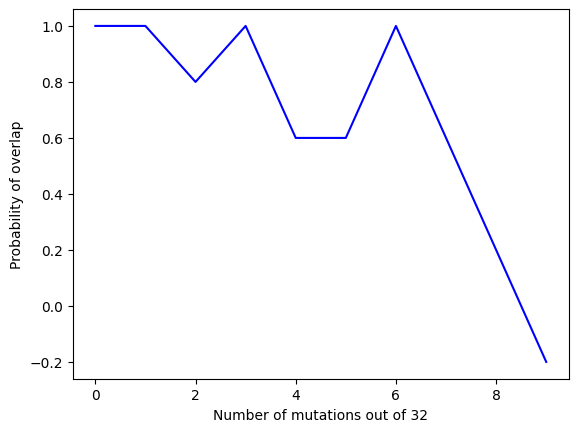

In [49]:

'''

Testing different sequence length and artifical mutatations with the Swap Test

This runs for ever - we are supposed to simulate the impact of noise


'''




@qml.qnode(dev)
def SWAP_test(seq1,seq2,qubits):

    '''
    There are 2 quantum state of equal size - each one of size (qubits-1)/2
    
    '''

    enc_seq1=DNA_encoder_complex(seq1)
    enc_seq2=DNA_encoder_complex(seq2)

    qml.AmplitudeEmbedding(features=enc_seq1, wires=range(1,int((qubits-1)/2+1)), normalize=True, pad_with=0.)
    qml.AmplitudeEmbedding(features=enc_seq2, wires=range(int((qubits-1)/2+1),qubits), normalize=True, pad_with=0.)

    #qml.AmplitudeEmbedding(features=enc_seq1, wires=range(1,5), normalize=True, pad_with=0.)
    #qml.AmplitudeEmbedding(features=enc_seq2, wires=range(5,9), normalize=True, pad_with=0.)

    qml.Hadamard(0)
    for i in range(1,int((qubits-1)/2+1)):
        qml.CSWAP(wires=[0, i, i+int((qubits-1)/2)])  # pairwise comparison of qubits
    qml.Hadamard(0)

    probs=qml.probs(wires=[0])

    return probs


for i in range (5,6):
    seq_len=2**i

    dev = qml.device('default.mixed', wires = range(2*i+1), shots = 100)
    
    seq_1=random_DNA_gen(50,seq_len)

    m=np.arange(10, dtype=int)
    probs=np.arange(10,dtype=float)
    for j in range (10):
        seq_2=mutate_seq(seq_1,j)
        prob=SWAP_test(seq_1,seq_2,2*i+1)
        probs[j]=prob[0]*2-1

    plt.plot(m,probs,color='b')
    plt.xlabel('Number of mutations out of '+ str(2**i))
    plt.ylabel('Probability of overlap')

    plt.show()



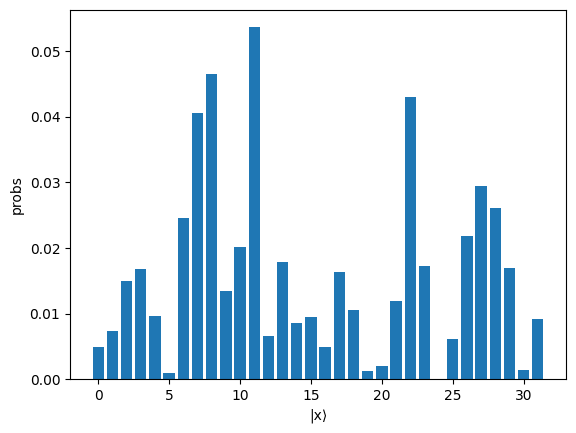

In [45]:

'''

Here we apply the QFT and display the spectrum

'''




@qml.qnode(dev)
def QFT_test(seq, qubits):


    enc_seq1=DNA_encoder_complex(seq)

    qml.AmplitudeEmbedding(features=enc_seq1, wires=range(1,qubits), normalize=True, pad_with=0.)
    
    qml.QFT(wires=range(0, qubits))

    return qml.probs(wires=range(0, qubits))


i=5
dev = qml.device('default.qubit', wires = range(2*i+1))
seq_len=2**i
seq=random_DNA_gen(95,seq_len)
#print(QFT_test(seq,i+1))

state = QFT_test(seq,i+1)[:2**i]

plt.bar(range(len(state)), state)
plt.xlabel("|x⟩")
plt.ylabel("probs")
plt.show()



In [34]:
dev = qml.device("lightning.qubit", wires=range(13))



@qml.qnode(dev)
def SWAP_test(seq1,seq2,qubits):

    '''
    There are 2 quantum state of equal size - each one of size (qubits-1)/2
    
    '''

    
    enc_seq1=DNA_encoder(seq1)
    enc_seq2=DNA_encoder(seq2)
    '''
    for i in range(1,int((qubits-1)/2+1)):
        qml.RX(enc_seq1[i], wires=i)

    for i in range(int((qubits-1)/2+1), qubits):
        qml.RX(enc_seq2[i-7], wires=i)

    '''

    for i in range(1,int((qubits-1)/2)+1):
        qml.RX(enc_seq1[i-1], wires=i)

    for i in range(7,13):
        qml.RX(enc_seq2[i-7], wires=i)
     

    qml.Hadamard(0)
    for i in range(1,7):
        qml.CSWAP(wires=[0, i, i+6])  # pairwise comparison of qubits
    qml.Hadamard(0)

    probs=qml.probs(wires=[0])

    return probs

seq_1=random_DNA_gen(90,6)
print(seq_1)
seq_2=random_DNA_gen(10,6)
print(seq_2)

prob=SWAP_test(seq_1, seq_2 ,13)
prob1=2*prob[0]-1

seq_1=random_DNA_gen(0,6)
seq_2=seq_1
print(seq_1,seq_2)

prob=SWAP_test(seq_1, seq_2 ,13)
prob2=2*prob[0]-1

print('Unequal seq:',prob1,'Equal seq:',prob2)


CGACGC
TAATTC
TAAAAA TAAAAA
Unequal seq: -1.1102230246251565e-16 Equal seq: 0.9999999999999991


In [32]:
dev = qml.device("lightning.qubit", wires=range(13))



@qml.qnode(dev)
def SWAP_test(seq1,seq2,qubits):

    '''
    There are 2 quantum state of equal size - each one of size (qubits-1)/2
    
    '''

    
    enc_seq1=DNA_encoder(seq1)
    enc_seq2=DNA_encoder(seq2)
    '''
    for i in range(1,int((qubits-1)/2+1)):
        qml.RX(enc_seq1[i], wires=i)

    for i in range(int((qubits-1)/2+1), qubits):
        qml.RX(enc_seq2[i-7], wires=i)

    '''

    for i in range(1,7):
        qml.RX(enc_seq1[i-1], wires=i)

    for i in range(7,13):
        qml.RX(enc_seq2[i-7], wires=i)
     

    qml.Hadamard(0)
    for i in range(1,7):
        qml.CSWAP(wires=[0, i, i+6])  # pairwise comparison of qubits
    qml.Hadamard(0)

    probs=qml.probs(wires=[0])

    return probs

seq_1=random_DNA_gen(90,6)
print(seq_1)
seq_2=random_DNA_gen(20,6)
print(seq_2)

prob=SWAP_test(seq_1, seq_2 ,13)
prob1=2*prob[0]-1

seq_1=random_DNA_gen(0,6)
seq_2=seq_1
print(seq_1,seq_2)

prob=SWAP_test(seq_1, seq_2 ,13)
prob2=2*prob[0]-1

print('Unequal seq:',prob1,'Equal seq:',prob2)


CCCCCG
TAATGC
AATTTT AATTTT
Unequal seq: 0.0625 Equal seq: 0.9999999999999998


In [24]:
dev = qml.device("lightning.qubit", wires=range(3))

'''

standard single swab test

pi rotation difference beyween gates - orthogonal - overlap is zero
equal size - overlap is 1


'''

@qml.qnode(dev)
def SWAP_test(rot1,rot2):

    '''
    There are 2 quantum state of equal size - each one of size (qubits-1)/2
    
    '''

    qml.RX(rot1, wires=1)
    qml.RX(rot2, wires=2)
     

    qml.Hadamard(0)
    qml.CSWAP(wires=[0, 1, 2])  # comparison of qubits
    qml.Hadamard(0)

    probs=qml.probs(wires=[0])

    return probs



prob=SWAP_test(np.pi,0)
prob=prob[0]*2-1
print('Orthogonol: ',prob)

prob=SWAP_test(-np.pi/2,-np.pi/2)
prob=prob[0]*2-1
print('Equal: ',prob)

prob=SWAP_test(-np.pi/4,np.pi/4)
prob=prob[0]*2-1
print('50% overlap: ',prob)

prob=SWAP_test(0,np.pi/4)
prob=prob[0]*2-1
print('25% overlap: ',prob)

Orthogonol:  -4.440892098500626e-16
Equal:  0.9999999999999991
50% overlap:  0.49999999999999956
25% overlap:  0.8535533905932726


In [2]:
qml.about()

Name: PennyLane
Version: 0.36.0
Summary: PennyLane is a cross-platform Python library for quantum computing, quantum machine learning, and quantum chemistry. Train a quantum computer the same way as a neural network.
Home-page: https://github.com/PennyLaneAI/pennylane
Author: 
Author-email: 
License: Apache License 2.0
Location: /Users/brah/anaconda3/envs/Pennylane_new/lib/python3.11/site-packages
Requires: appdirs, autograd, autoray, cachetools, networkx, numpy, pennylane-lightning, requests, rustworkx, scipy, semantic-version, toml, typing-extensions
Required-by: PennyLane-qiskit, PennyLane_Lightning

Platform info:           macOS-12.6.3-arm64-arm-64bit
Python version:          3.11.8
Numpy version:           1.26.4
Scipy version:           1.12.0
Installed devices:
- default.clifford (PennyLane-0.36.0)
- default.gaussian (PennyLane-0.36.0)
- default.mixed (PennyLane-0.36.0)
- default.qubit (PennyLane-0.36.0)
- default.qubit.autograd (PennyLane-0.36.0)
- default.qubit.jax (PennyLane